In [ ]:
!pip install docx2txt
!pip install PyPDF2
!pip install pdfreader
!pip install pdfminer
!pip install nltk
!pip install resume-parser
!pip install spacytextblob

In [ ]:
#importing all required libraries

import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

#docx resume
import docx2txt

#pdf resume
import io
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage


#Wordcloud
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download("wordnet")
nltk.download("brown")
nltk.download("maxent_ne_chunker")
import re
import operator

from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
set(stopwords.words('english'))
from wordcloud import WordCloud
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from spacy.matcher import Matcher
import pickle
import random
import numpy as np

import random
import string


import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [124]:
#Function to read resumes from the folder one by one
mypath='/content/Resume' #enter your path here where you saved the resumes
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
print(onlyfiles)


['/content/Resume/10553553.pdf', '/content/Resume/10839851.pdf', '/content/Resume/11957080.pdf', '/content/Resume/Lucius Resume 22012022.docx', '/content/Resume/10641230.pdf', '/content/Resume/Lucius Resume 191219.pdf', '/content/Resume/10840430.pdf', '/content/Resume/11584809.pdf', '/content/Resume/Lucius Resume 23012022(test).docx', '/content/Resume/Lucius Resume 3112021.pdf', '/content/Resume/11580408.pdf']


In [125]:
#Read PDF Resume
def read_pdf_resume(pdf_doc):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    
    with open(pdf_doc, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
            
        text = fake_file_handle.getvalue()
    
    # close open handles
    converter.close()
    fake_file_handle.close()
    
    if text:
        return text

        

In [126]:
#Read Word Resume
def read_word_resume(word_doc):
    #resume = docx2txt.process(word_doc)
    #text = ''.join(resume)
    resume = docx2txt.process(word_doc)
    resume = str(resume)
    #print(resume)
    text =  ''.join(resume)
    text = text.replace("\n", "")
    
    if text:
        return text
    

In [127]:
def create_profile(file):
    text = read_pdf_resume(file) 
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = {'Ideation':['black belt','capability analysis','control charts','doe','dmaic','fishbone',
                              'gage r&r', 'green belt','ishikawa','iso','kaizen','kpi','lean','metrics',
                              'pdsa','performance improvement','process improvement','quality',
                              'quality circles','quality tools','root cause','six sigma',
                              'stability analysis','statistical analysis','tqm'],      
        'Teamwork':['automation','bottleneck','constraints','cycle time','efficiency','fmea',
                                 'machinery','maintenance','manufacture','line balancing','oee','operations',
                                 'operations research','optimization','overall equipment effectiveness',
                                 'pfmea','process','process mapping','production','resources','safety',
                                 'stoppage','value stream mapping','utilization'],
        'Change Management':['abc analysis','apics','customer','customs','delivery','distribution','eoq','epq',
                        'fleet','forecast','inventory','logistic','materials','outsourcing','procurement',
                        'reorder point','rout','safety stock','scheduling','shipping','stock','suppliers',
                        'third party logistics','transport','transportation','traffic','supply chain',
                        'vendor','warehouse','wip','work in progress'],
        'Collaboration':['administration','agile','budget','cost','direction','feasibility analysis',
                              'finance','kanban','leader','leadership','management','milestones','planning',
                              'pmi','pmp','problem','project','risk','schedule','scrum','stakeholders'],
        'Digital Literacy':['analytics','api','aws','big data','busines intelligence','clustering','code',
                          'coding','data','database','data mining','data science','deep learning','hadoop',
                          'hypothesis test','iot','internet','machine learning','modeling','nosql','nlp',
                          'predictive','programming','python','r','sql','tableau','text mining',
                          'visualuzation'],
        'Client Orientation':['adverse events','care','clinic','cphq','ergonomics','healthcare',
                      'health care','health','hospital','human factors','medical','near misses',
                      'patient','reporting system']}
    stats_words = [nlp(text) for text in keyword_dict['Ideation']]
    NLP_words = [nlp(text) for text in keyword_dict['Teamwork']]
    ML_words = [nlp(text) for text in keyword_dict['Change Management']]
    DL_words = [nlp(text) for text in keyword_dict['Collaboration']]
    R_words = [nlp(text) for text in keyword_dict['Digital Literacy']]
    python_words = [nlp(text) for text in keyword_dict['Client Orientation']]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Ideation', None, *stats_words)
    matcher.add('Teamwork', None, *NLP_words)
    matcher.add('CM', None, *ML_words)
    matcher.add('Collaboration', None, *DL_words)
    matcher.add('DL', None, *R_words)
    matcher.add('CO', None, *python_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())


    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf = dataf.convert_dtypes()
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

    return(dataf)

In [128]:
#Phrase matching and candidate profile (PDF)

def create_profile2(file):
    text = read_word_resume(file) 
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = {'Ideation':['black belt','capability analysis','control charts','doe','dmaic','fishbone',
                              'gage r&r', 'green belt','ishikawa','iso','kaizen','kpi','lean','metrics',
                              'pdsa','performance improvement','process improvement','quality',
                              'quality circles','quality tools','root cause','six sigma',
                              'stability analysis','statistical analysis','tqm'],      
        'Teamwork':['automation','bottleneck','constraints','cycle time','efficiency','fmea',
                                 'machinery','maintenance','manufacture','line balancing','oee','operations',
                                 'operations research','optimization','overall equipment effectiveness',
                                 'pfmea','process','process mapping','production','resources','safety',
                                 'stoppage','value stream mapping','utilization'],
        'Change Management':['abc analysis','apics','customer','customs','delivery','distribution','eoq','epq',
                        'fleet','forecast','inventory','logistic','materials','outsourcing','procurement',
                        'reorder point','rout','safety stock','scheduling','shipping','stock','suppliers',
                        'third party logistics','transport','transportation','traffic','supply chain',
                        'vendor','warehouse','wip','work in progress'],
        'Collaboration':['administration','agile','budget','cost','direction','feasibility analysis',
                              'finance','kanban','leader','leadership','management','milestones','planning',
                              'pmi','pmp','problem','project','risk','schedule','scrum','stakeholders'],
        'Digital Literacy':['analytics','api','aws','big data','busines intelligence','clustering','code',
                          'coding','data','database','data mining','data science','deep learning','hadoop',
                          'hypothesis test','iot','internet','machine learning','modeling','nosql','nlp',
                          'predictive','programming','python','r','sql','tableau','text mining',
                          'visualuzation'],
        'Client Orientation':['adverse events','care','clinic','cphq','ergonomics','healthcare',
                      'health care','health','hospital','human factors','medical','near misses',
                      'patient','reporting system']}
    stats_words = [nlp(text) for text in keyword_dict['Ideation']]
    NLP_words = [nlp(text) for text in keyword_dict['Teamwork']]
    ML_words = [nlp(text) for text in keyword_dict['Change Management']]
    DL_words = [nlp(text) for text in keyword_dict['Collaboration']]
    R_words = [nlp(text) for text in keyword_dict['Digital Literacy']]
    python_words = [nlp(text) for text in keyword_dict['Client Orientation']]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Ideation', None, *stats_words)
    matcher.add('Teamwork', None, *NLP_words)
    matcher.add('CM', None, *ML_words)
    matcher.add('Collaboration', None, *DL_words)
    matcher.add('DL', None, *R_words)
    matcher.add('CO', None, *python_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())

   

    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))

    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2), names = ['Candidate Name'])

    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf = dataf.convert_dtypes()
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)


    return(dataf)

In [129]:
#Code to match resume with JD
job_description = docx2txt.process("/content/Sample JD.docx")

In [204]:
#Find Percentage mactch to job description
def match(text):

  cv = CountVectorizer()
  count_matrix = cv.fit_transform(text)

  matchPercentage = cosine_similarity(count_matrix)[0][1] * 100
  matchPercentage = round(matchPercentage, 2) # round to two decimal

  return(matchPercentage)

In [131]:
#find important information pdf
def extractdetails(resume):

    s = resume
    lst = re.findall('\S+@\S+|$', s)[0]   
    
    return(lst)


In [132]:
#Create Random Number
def randomid():

    random1 = ''.join([random.choice(string.ascii_letters
            + string.digits) for n in range(10)])

    return(random1)

In [133]:
def getphone(resume):
    phone = re.findall(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]|$', resume)[0]
    return(phone)


In [169]:
# load pre-trained model
nlp = spacy.load('en_core_web_sm')

# initialize matcher with a vocab
matcher = Matcher(nlp.vocab)

def extract_name(resume):
   nlp_text = nlp(resume)
  
   # First name and Last name are always Proper Nouns
   pattern = [{'POS': 'PROPN'}, {'POS': 'PROPN'}]
  
   matcher.add('NAME',[pattern], on_match=None,)
  
   matches = matcher(nlp_text)
  
   for match_id, start, end in matches:
       span = nlp_text[start:end]
       return span.text


In [135]:
#find linkedin profile might have extended characters
def extract_linkin(resume):
    link = re.findall('linkedin(?:[a-zA-Z]|[0-9]|[$-_])+|$', resume)[0]

    return(link)



In [136]:
#Find most popular words

def mostpopularword(resume):

    resumeText = resume
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace

    oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
    totalWords =[]
    requiredWords = nltk.word_tokenize(resumeText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
    wordfreqdist = nltk.FreqDist(totalWords)
    mostcommon = wordfreqdist.most_common(10)
    return(mostcommon)

In [137]:
#Job Matching to position

def job_match(resume):
    text = resume
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = {'HR Executive':['J2EE', 'Oracle Fusion', 'Oracle Cloud', 'Salesforce', 'Devops Android', 
                                    'Business Analyst', 'UI Developer', 'DBAs', 'Embedded Systems', '.NET', 
                                    'Hadoop', 'SQL Developer', 'Big Data', 'Tableau', 'Networking', 'Etl', 
                                    'Informatica', 'Ios', 'Quality Analyst', 'Project Manager', 'Python'],      
        'HR Analysis':['Data Science', 'Python', 'Machine Learning', 'SAS', 
                       'Java', 'Scala', 'Hadoop', 'Hive', 'Bigdata', 'Programming', 
                       'SQL server reporting', 'Msbi', 'Ssrs', 'Msbi', 'Sql', 'Artificial Intelligence', 
                       'Pandas', 'Pyspark', 'Sklearn', 'Flask', 'Django', 'Map Reduce', 'Parametric Design', 
                       'Modeling', 'Regression', 'Patterns', 'Data Mining', 'Text Mining', 'Oops', 'Deep Learning', 
                       'Web Analytics', 'Time Series', 'Regression', 'Tensorflow', 'Azure', 'Linear Regression', 
                       'Logistic Regression', 'Decision Tree', 'Random Forest', 'Data Structure', 'Computer Vision'],
        'HR Manager':['abc analysis','apics','customer','customs','delivery','distribution','eoq','epq',
                        'fleet','forecast','inventory','logistic','materials','outsourcing','procurement',
                        'reorder point','rout','safety stock','scheduling','shipping','stock','suppliers',
                        'third party logistics','transport','transportation','traffic','supply chain',
                        'vendor','warehouse','wip','work in progress'],
        'Project Analaysis':['administration','agile','budget','cost','direction','feasibility analysis',
                              'finance','kanban','leader','leadership','management','milestones','planning',
                              'pmi','pmp','problem','project','risk','schedule','scrum','stakeholders'],
        'Data analytics':['analytics','api','aws','big data','busines intelligence','clustering','code',
                          'coding','data','database','data mining','data science','deep learning','hadoop',
                          'hypothesis test','iot','internet','machine learning','modeling','nosql','nlp',
                          'predictive','programming','python','r','sql','tableau','text mining',
                          'visualuzation'],
        'HR Supervisor':['adverse events','care','clinic','cphq','ergonomics','healthcare',
                      'health care','health','hospital','human factors','medical','near misses',
                      'patient','reporting system']}
        # Initializie score counters for each area
    quality = 0
    operations = 0
    supplychain = 0
    project = 0
    data = 0
    healthcare = 0

      # Create an empty list where the scores will be stored
    scores = []

        # Obtain the scores for each area
    for area in keyword_dict.keys():
                
            if area == 'HR Executive':
                for word in keyword_dict[area]:
                    if word in text:
                        quality +=1
                scores.append(quality)
                
            elif area == 'HR Analysis':
                for word in keyword_dict[area]:
                    if word in text:
                        operations +=1
                scores.append(operations)
                
            elif area == 'HR Manager':
                for word in keyword_dict[area]:
                    if word in text:
                        supplychain +=1
                scores.append(supplychain)
                
            elif area == 'Project Analaysis':
                for word in keyword_dict[area]:
                    if word in text:
                        project +=1
                scores.append(project)
                
            elif area == 'Data analytics':
                for word in keyword_dict[area]:
                    if word in text:
                        data +=1
                scores.append(data)
                
            else:
                for word in keyword_dict[area]:
                    if word in text:
                        healthcare +=1
                scores.append(healthcare)

    summary = pd.DataFrame(scores,index=keyword_dict.keys(),columns=['score']).sort_values(by='score',ascending=False)
    summary1 = summary['score'].idxmax() 

    return(summary1)


In [203]:
#skills 

# you may read the database from a csv file or some other database
SKILLS_DB = [
    'machine learning',
    'data science',
    'python',
    'word',
    'excel',
    'english','technology','management','analysis','digital','workflow','data management','effectiveness','Productivity','Learning','Passion','Website',
    'approval','office 365','migration','HTML5','CSS3','project','J2EE', 'Oracle Fusion', 'Oracle Cloud', 'Salesforce', 'Devops Android', 
                                    'Business Analyst', 'UI Developer', 'DBAs', 'Embedded Systems', '.NET', 
                                    'Hadoop', 'SQL Developer', 'big data', 'tableau', 'Networking', 'Etl', 
                                    'Informatica', 'Ios', 'Quality Analyst', 'project manager', 'Python',]
 
 
 
def extract_skills(resume):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(resume)
 
    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]
 
    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]
 
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(filtered_tokens, 2, 3)))
 
    # we create a set to keep the results in.
    found_skills = set()
 
    # we search for each token in our skills database
    for token in filtered_tokens:
        if token.lower() in SKILLS_DB:
            found_skills.add(token)
 
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SKILLS_DB:
            found_skills.add(ngram)
 
    return found_skills
 

In [139]:
#Education
def education_profile(resume):
    text = resume
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = {'Secondary':['10th','X,Matric','SSC'],      
        'Diploma':['CDAC', 'PGDBM','diploma in'],
        'Bachelors':['BE','B.E.','BTech','B.Tech','BS','Mechanical','Instrumentation','Civil','singapore university of social science']}

    Secondary_words = [nlp(text) for text in keyword_dict['Secondary']]
    Diploma_words = [nlp(text) for text in keyword_dict['Diploma']]
    Bachelors_words = [nlp(text) for text in keyword_dict['Bachelors']]


    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Secondary', None, *Secondary_words)
    matcher.add('Diploma', None, *Diploma_words)
    matcher.add('Bachelors', None, *Bachelors_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)

    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        return(span)
        d.append((rule_id, span.text))      
    #keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())



    return(d)

In [ ]:
#clean Resume
final_database1=pd.DataFrame()
final_database2=pd.DataFrame()

list1 = []
list2 = []

namelist1 = []
namelist2 = []

detailslist1=[]
detailslist2=[]

randomlist1 = []
randomlist2 = []

cname1 = []
cname2 = []

phone1 = []
phone2 = []

linkedin1 = []
linkedin2 = []

Joblist1 = []
Joblist2 = []

resume1 = []
resume2 = []

skills_1 = []
skills_2 = []

skillcount1 = []
skillcount2 = []

education1 = []

i = 0
while i < len(onlyfiles):
    file = onlyfiles[i]
    if file.endswith(".pdf"):
      resume = read_pdf_resume(file)
      #Match to Job Description
      text1 = [resume, job_description]
      match1 = match(text1)
      list1.append(match1)

      #Create & Append File
      dat = create_profile(file)
      final_database1 = final_database1.append(dat)


      #Check filename
      base = os.path.basename(file)
      filename = os.path.splitext(base)[0]
      name = filename.split('_')
      name2 = name[0]
      name2 = name2.lower()
      namelist1.append(name2)


      #Extract details
      details1 = extractdetails(resume) 
      detailslist1.append(details1)

      #Random ID
      randomid1 = randomid()
      randomlist1.append(randomid1)

      #Extract Name
      cname = extract_name(resume)
      cname1.append(cname)

      #extract phone
      phone = getphone(resume)
      phone1.append(phone)

      #extract linkedin
      linkedin = extract_linkin(resume)
      linkedin1.append(linkedin)

      #most common word
      mostcommon = mostpopularword(resume)

      #Job Recommendation
      Job1 = job_match(resume)
      Joblist1.append(Job1)

      #append clean resume to list & dataframe to build machine learning model
      resume1.append(resume)

      #skills
      skills = extract_skills(resume)
      s = list(skills)
      string_list = [each_string.lower() for each_string in s]
      final_new_menu = list(dict.fromkeys(string_list))
      test1 = len(final_new_menu)
      skills_1.append(final_new_menu)
      skillcount1.append(test1)


      #Education
      education = education_profile(resume)
      education1.append(education)

      

      i +=1


    elif file.endswith("docx"):
      resume = read_word_resume(file)
       #Match to Job Description
      text2 = [resume, job_description]
      match2 = match(text2)
      list2.append(match2)

      #Create & Append File
      dat = create_profile2(file)
      final_database2 = final_database2.append(dat)

      
      
      base = os.path.basename(file)
      filename = os.path.splitext(base)[0]
      name = filename.split('_')
      name2 = name[0]
      name2 = name2.lower()
      namelist2.append(name2)

      #Extract details
      details2 = extractdetails(resume) 
      detailslist2.append(details2)

      #Random ID
      randomid1 = randomid()
      randomlist2.append(randomid1)

      #Extract Name
      cname = extract_name(resume)
      cname2.append(cname)

      #extract phone
      phone = getphone(resume)
      phone2.append(phone)

      #extract linkedin
      linkedin = extract_linkin(resume)
      linkedin2.append(linkedin)

      #Job Recommendation
      Job1 = job_match(resume)
      Joblist2.append(Job1)

      #append clean resume to list & dataframe to build machine learning model
      resume2.append(resume)

      #skills
      skills = extract_skills(resume)
      s = list(skills)
      string_list = [each_string.lower() for each_string in s]
      final_new_menu = list(dict.fromkeys(string_list))
      test1 = len(final_new_menu)
      skills_2.append(final_new_menu)
      skillcount2.append(test1)


      i +=1


frames = [final_database1, final_database2]
result = pd.concat(frames)


#Candidate Email
df8 = pd.DataFrame(detailslist1,columns = ['Candidate Email'])
df9 = pd.DataFrame(detailslist2,columns = ['Candidate Email'])
frames6 = [df8, df9]
result7 = pd.concat(frames6, ignore_index=True)

#Random Number
df10 = pd.DataFrame(randomlist1,columns = ['Candidate ID'])
df11 = pd.DataFrame(randomlist2,columns = ['Candidate ID'])
frames7 = [df10, df11]
result8 = pd.concat(frames7, ignore_index=True)

#Candidate Name
df12 = pd.DataFrame(cname1,columns = ['Candidate Name1'])
df13 = pd.DataFrame(cname2,columns = ['Candidate Name1'])
frames9 = [df12, df13]
result9 = pd.concat(frames9, ignore_index=True)

#Candidate Name
df14 = pd.DataFrame(Joblist1,columns = ['Recommended Job'])
df15 = pd.DataFrame(Joblist2,columns = ['Recommended Job'])
frames10 = [df14, df15]
result10 = pd.concat(frames10, ignore_index=True)

#Candidate Name
df16 = pd.DataFrame(resume1,columns = ['Cleaned Resume'])
df17 = pd.DataFrame(resume2,columns = ['Cleaned Resume'])
frames11 = [df16, df17]
result11 = pd.concat(frames11, ignore_index=True)

#Candidate Phone Number
df18 = pd.DataFrame(phone1,columns = ['Contact Number'])
df19 = pd.DataFrame(phone2,columns = ['Contact Number'])
frames12 = [df18, df19]
result12 = pd.concat(frames12, ignore_index=True)

#Candidate Phone Number
df20 = pd.DataFrame(linkedin1,columns = ['Linkedin'])
df21 = pd.DataFrame(linkedin2,columns = ['Linkedin'])
frames13 = [df20, df21]
result14 = pd.concat(frames13, ignore_index=True)



#skills
df24 = pd.DataFrame(skillcount1,columns = ['skillcount'])
df22 = pd.DataFrame({'skills':skills_1})
df30 = df22.join(df24)
df25 = pd.DataFrame(skillcount2,columns = ['skillcount'])
df23 = pd.DataFrame({'skills':skills_2})
df31 = df25.join(df23)
frames15 = [df30,df31]
result16 = pd.concat(frames15, ignore_index=True)


print(result16)
print(result)


In [206]:
 #Build new data frame

data1 = pd.DataFrame(list1, columns = ['Percentage'])
data2 = pd.DataFrame(list2, columns = ['Percentage'])
frames1 = [data1, data2]
result1 = pd.concat(frames1,ignore_index=True)

data3 = pd.DataFrame(namelist1, columns = ['Candidate Name'])
data4 = pd.DataFrame(namelist2, columns = ['Candidate Name'])
frames2 = [data3, data4]
result2 = pd.concat(frames2,ignore_index=True)


result3 = pd.concat([result2,result1,result7,result8,result9,result10,result12,result14,result16,result11],axis = 1)

print(result3)
print(result3.head(5))

                  Candidate Name  ...                                     Cleaned Resume
0                       10553553  ...  INFORMATION TECHNOLOGY MANAGERSummaryDedicated...
1                       10839851  ...  INFORMATION TECHNOLOGY SPECIALISTProfessional ...
2                       11957080  ...  LEAD INFORMATION TECHNOLOGY SUPPORT SPECIALIST...
3                       10641230  ...  IT MANAGEMENTCareer OverviewDetail-oriented pr...
4           lucius resume 191219  ...    Lucius Gwee +65 9327 8558    | lgweeyy@hotma...
5                       10840430  ...  BRANCH CHIEF INFORMATION TECHNOLOGY SPECIALIST...
6                       11584809  ...  MANAGER - INFORMATION TECHNOLOGY AND BUILDING ...
7          lucius resume 3112021  ...    Lucius Gwee +65 9327 8558    | lgweeyy@hotma...
8                       11580408  ...  INFORMATION TECHNOLOGY COORDINATORCareer Overv...
9         lucius resume 22012022  ...  2Lucius Gwee+65 9327 8558    | lgweeyy@hotmail...
10  lucius resume 230

In [207]:
#Code to count each word in category and convert to excel sheet
print(result)


result['Candidate Name'] = result['Candidate Name'].astype(str)
final_database2 = result['Keyword'].groupby([result['Candidate Name'],result['Subject']]).count().unstack()

print(final_database2)

final_database3 = final_database2.sum(axis =1)
column_sum = len(final_database2.columns)
match = round(column_sum/100*final_database3,1)

final_database2['Sum'] = final_database3
final_database2['Overall'] = match
final_database2['Job Position'] = 'HR Executive'
final_database2['Job Portal'] = ''

                  Candidate Name        Subject       Keyword Count
0                       10553553  Collaboration         risk      1
1                       10553553  Collaboration         cost      1
2                       10553553       Teamwork    resources      1
3                       10553553             CM     customer      3
4                       10553553  Collaboration       budget      2
..                           ...            ...           ...   ...
11  lucius resume 23012022(test)             DL  programming      1
12  lucius resume 23012022(test)             CM       vendor      1
13  lucius resume 23012022(test)             CO         care      1
14  lucius resume 23012022(test)             DL            r      1
15  lucius resume 23012022(test)             DL       coding      1

[150 rows x 4 columns]
Subject                        CM   CO  Collaboration    DL  Ideation  Teamwork
Candidate Name                                                                 


In [208]:
#Join Data frmae tg


result3['Candidate Name'] = result3['Candidate Name'].astype(str)



final_database5 = final_database2.merge(result3,on = 'Candidate Name')

# Competency Total
# create a list of our conditions
conditions = [
    (final_database5['Sum'] <= 5),
    (final_database5['Sum'] > 5) & (final_database5['Sum'] <= 10),
    (final_database5['Sum'] > 10) & (final_database5['Sum'] <= 20),
    (final_database5['Sum'] > 20) & (final_database5['Sum'] <= 30),
    (final_database5['Sum'] > 30)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']


# create a new column and use np.select to assign values to it using our lists as arguments
final_database5['Competency Total'] = np.select(conditions, values)

# Resume Match Total
# create a list of our conditions
conditions = [
    (final_database5['Percentage'] <= 50),
    (final_database5['Percentage'] > 50) & (final_database5['Percentage'] <= 60),
    (final_database5['Percentage'] > 60) & (final_database5['Percentage'] <= 70),
    (final_database5['Percentage'] > 70) & (final_database5['Percentage'] <= 80),
    (final_database5['Percentage'] > 80)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
final_database5['Resume Match Total'] = np.select(conditions, values)

# Skill Count Total
# create a list of our conditions
conditions = [
    (final_database5['skillcount'] <= 3),
    (final_database5['skillcount'] > 3) & (final_database5['skillcount'] <= 5),
    (final_database5['skillcount'] > 5) & (final_database5['skillcount'] <= 7),
    (final_database5['skillcount'] > 7) & (final_database5['skillcount'] <= 10),
    (final_database5['skillcount'] > 10)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
final_database5['Skill Match Total'] = np.select(conditions, values)

# Skill Count Total
# create a list of our conditions
conditions = [
    (final_database5['Job Position'] == final_database5['Recommended Job']),
    (final_database5['Job Position'] != final_database5['Recommended Job'])
    ]

# create a list of the values we want to assign for each condition
values = ['1', '5']

# create a new column and use np.select to assign values to it using our lists as arguments
final_database5['Job Match Total'] = np.select(conditions, values)



#final_database5['Competency Total'] = final_database5['Competency Total'].astype(float)
#final_database5['competency_adjusted'] = 0.25 * final_database5['Competency Total']
#print(final_database5['competency_adjusted'])


final_database5['Competency Total'] = final_database5['Competency Total'].astype('int')
final_database5['Resume Match Total'] = final_database5['Resume Match Total'].astype('int')
final_database5['Skill Match Total'] = final_database5['Skill Match Total'].astype('int')
final_database5['Job Match Total'] = final_database5['Job Match Total'].astype('int')

column_list = ['Competency Total', 'Resume Match Total', 'Skill Match Total','Job Match Total']

print(column_list)

final_database5['Total Score'] =  final_database5[column_list].sum(axis=1)



final_database5.reset_index(inplace = False)
final_database5.fillna(0,inplace=True)
new_data = final_database5.iloc[:,1:]
new_data.index = final_database5['Candidate Name']

#execute the below line if you want to see the candidate profile in a csv format
new_data.to_csv('sample.csv')


print(new_data)

['Competency Total', 'Resume Match Total', 'Skill Match Total', 'Job Match Total']
                               CM   CO  ...  Job Match Total  Total Score
Candidate Name                          ...                              
10553553                      1.0  0.0  ...                5           13
10641230                      0.0  1.0  ...                5           12
10839851                      1.0  0.0  ...                5           11
10840430                      2.0  0.0  ...                5           15
11580408                      2.0  0.0  ...                5           11
11584809                      4.0  0.0  ...                5           14
11957080                      4.0  2.0  ...                5           15
lucius resume 191219          2.0  0.0  ...                5           15
lucius resume 22012022        1.0  0.0  ...                5           16
lucius resume 23012022(test)  1.0  1.0  ...                5           16
lucius resume 3112021        

In [220]:
new_data2 = new_data.drop(columns = ['Job Position','Job Portal','Candidate Email','Candidate ID','Candidate Name1','Recommended Job','Contact Number','Linkedin','skills','Cleaned Resume'], axis=1)
x = new_data2.drop('Total Score',axis=1)

In [221]:
y = new_data['Total Score'].apply(lambda y_value: 2 if y_value >=14 else (1 if (y_value >= 8 and y_value <= 13) else 0))

In [222]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=40)

In [223]:
# importing modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
#creating RandomForestClassifier constructor
rnd = DecisionTreeClassifier()
# fit data
fit_rnd = rnd.fit(x_train,y_train)
# predicting score
rnd_score = rnd.score(x_test,y_test)
print('score of model is : ',rnd_score)

score of model is :  1.0


In [224]:
# accuracy on test data
X_test_prediction = rnd.predict(x_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print('Accuracy : ', test_data_accuracy)

Accuracy :  1.0


In [225]:
x_predict = list(rnd.predict(x_test))
predicted_df = {'predicted_values': x_predict, 'original_values': y_test}
#creating new dataframe
df100 = pd.DataFrame(predicted_df)

df100['Candidate Quality'] = np.where(df100['predicted_values'] == 2 , 'Good Candidate', 'Bad Candidate')
print(df100)

                        predicted_values  original_values Candidate Quality
Candidate Name                                                             
10840430                               2                2    Good Candidate
11580408                               1                1     Bad Candidate
lucius resume 22012022                 2                2    Good Candidate


In [226]:
x_predict2 = rnd.predict(x)
new_data2['Predicted_Score'] = x_predict2
r_prediction = new_data2['Predicted_Score']

final_data = new_data.merge(r_prediction,on = 'Candidate Name')

# Predicted_Score
# create a list of our conditions
conditions = [
    (final_data['Predicted_Score'] == 0),
    (final_data['Predicted_Score'] == 1),
    (final_data['Predicted_Score'] == 2)
    ]

# create a list of the values we want to assign for each condition
values = ['Bad Candidate', 'Average Candidate', 'Good Candidate']

# create a new column and use np.select to assign values to it using our lists as arguments
final_data['Candidate Quality'] = np.select(conditions, values)

final_data1 = final_data.drop(columns = ['Cleaned Resume'], axis=1)

final_data2 = final_data1[['Candidate Name1','Candidate ID','Candidate Email','Contact Number','Linkedin','Job Position','Job Portal','CM','CO','Collaboration','DL','Ideation','Teamwork','Sum','Overall','Percentage','skills','Recommended Job','skillcount','Competency Total','Resume Match Total','Skill Match Total','Job Match Total','Total Score','Predicted_Score','Candidate Quality']]

final_data2.to_csv('Resume_data.csv')

In [227]:
input_data = (0.0,1.0,2.0,0.0,0.0,3.0,6.0,0.4,64.44,1,2,3,1,5)

# changing the input data to a numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the data as we are predicting the label for only one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = rnd.predict(input_data_reshaped)
print(prediction)

if (prediction[0]==1):
  print('Good Quality Wine')
else:
  print('Bad Quality Wine')

[1]
Good Quality Wine


In [228]:
#Visualise without overall
final2 = result['Keyword'].groupby([result['Candidate Name'], result['Subject']]).count().unstack()
final2.reset_index(inplace = True)
final2.fillna(0,inplace=True)
new_data2 = final2.iloc[:,1:]
new_data2.index = final2['Candidate Name']

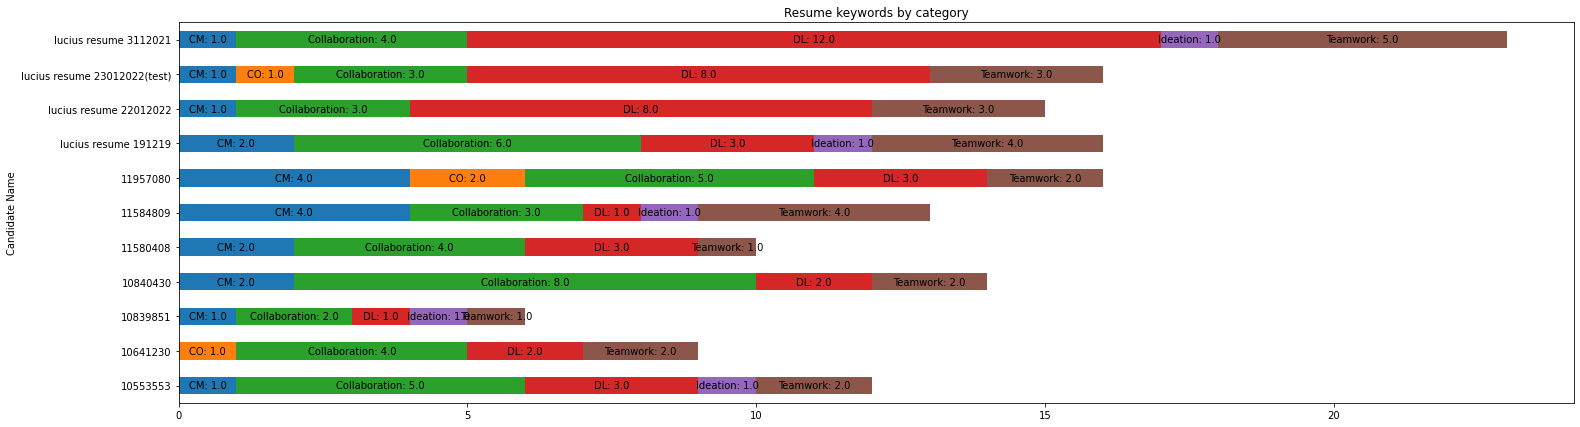

In [229]:
#Visualise
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data2.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in new_data2.columns:
    for i in new_data2.index:
        label = str(j)+": " + str(new_data2.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()